In [23]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import glob
pd.options.mode.chained_assignment = None 

In [24]:
import sys
import os
from pathlib import Path
import json 
import os
sys.path.append(os.path.join(Path.cwd().parent, 'src' ) ) 
sys.path.append(os.path.join(Path.cwd().parent, 'src' , 'utils') ) 
sys.path.append(os.path.join(Path.cwd().parent))
print(sys.path)
from utils import load__concat_data_fivepin, create_plot_fivepin, create_stack_bar_5pin
from utils import process_data , apply_response_five_pin

['/Users/yangzejia/Desktop/Intention/notebooks', '/Users/yangzejia/anaconda3/lib/python311.zip', '/Users/yangzejia/anaconda3/lib/python3.11', '/Users/yangzejia/anaconda3/lib/python3.11/lib-dynload', '', '/Users/yangzejia/Desktop/Intention/claude-env/lib/python3.11/site-packages', '/Users/yangzejia/Desktop/Intention/src', '/Users/yangzejia/Desktop/Intention/src/utils', '/Users/yangzejia/Desktop/Intention', '/Users/yangzejia/Desktop/Intention/src', '/Users/yangzejia/Desktop/Intention/src/utils', '/Users/yangzejia/Desktop/Intention']


In [25]:
test_name = "claude-family"
file_dir = f'/Users/yangzejia/Desktop/Intention/reports/figures/{test_name}'
os.makedirs(file_dir, exist_ok=True)
run_name = 'gpt-4-dataset-V2'
models =  [ 
            ("claude-3-haiku-20240307", 0, False),
            ("claude-3-haiku-20240307", 0, True),
            ("claude-3-haiku-20240307", 2, False),
            ("claude-3-haiku-20240307", 4, False),
            ("claude-3-haiku-20240307", 6, False),
            # ("claude-3-sonnet-20240229", False, 0),
            ("claude-3-sonnet-20240229-2", 0, False),
            ("claude-3-sonnet-20240229", 0, True),
            ("claude-3-sonnet-20240229", 2, False),
            ("claude-3-sonnet-20240229", 4, False),
            ("claude-3-sonnet-20240229", 6, False),
            ("claude-3-opus-20240229", 0, False),
            ("claude-3-opus-20240229", 0, True),
            ("claude-3-opus-20240229", 2, False),
            ("claude-3-opus-20240229", 4, False),
            ("claude-3-opus-20240229", 6, False),
            ]


In [26]:
import re
def load_files(model_name, run_name, numex = 0, cot=False):
    if numex == 0 and not cot:
        file_path = f'/Users/yangzejia/Desktop/Intention/data/processed/model--{model_name}/d_name--{run_name}/'
    elif numex == 0 and cot:
        file_path = f'/Users/yangzejia/Desktop/Intention/data/processed_chainofthought/model--{model_name}/d_name--{run_name}/'
    else: 
        file_path = f'/Users/yangzejia/Desktop/Intention/data/processed_fewshot_{numex}/model--{model_name}/d_name--{run_name}/'

    files = glob.glob(f'{file_path}/*/*.json')

    if len(files) != 38:
        print('ERROR: Not all topics have been processed')
    print(len(files))
    helpful_df, harmful_df   = process_for_plots(files , model_name, run_name  )
    return helpful_df, harmful_df 

# def process_model(model_name, run_name, fewshot = False, numex = 0):
#     print(model_name)
#     if not fewshot :
#         file_path = f'/Users/yangzejia/Desktop/Intention/data/processed/model--{model_name}/d_name--{run_name}/'
#     else :
#         file_path = f'/Users/yangzejia/Desktop/Intention/data/processed_fewshot_{numex}/model--{model_name}/d_name--{run_name}/'

#     files = glob.glob(f'{file_path}/*/*.json')

#     if len(files) != 38:
#         print('ERROR: Not all topics have been processed')
        
#     helpful_df, harmful_df   = process_for_plots(files , model_name, run_name  )
#     helpful_df, harmful_df = process_for_plots(files , model_name, run_name  )
#     fig, ax = plt.subplots(nrows = 1 , ncols = 2, figsize = (10,10) , sharey= True) 
#     ax=ax.ravel() 

#     help(fig, ax[0], helpful_df, model_name)

#     harm(fig, ax[1], harmful_df, model_name)


#     fig.savefig(f'/Users/yangzejia/Desktop/Intention/reports/figures/{model_name}_{run_name}_comparison.png', bbox_inches='tight', )    
    
len_to_check = 10 

def process_for_plots(files , model_name, run_name ):
    # List to store each file's DataFrame
    print(model_name)
    dfs = []

    # Loop over each file in the folder
    for file in files:
        with open(file, 'r') as f:
            data = json.load(f)
            if len(data) < len_to_check:
                print(len(data))
                print(f'ERROR: {file} has less than {len_to_check} entries')
                # exit()
            # Convert JSON data to a DataFrame
            # This assumes that your JSON structure is a list of records
            if isinstance(data, list):
                df = pd.DataFrame(data)
                dfs.append(df)
            else:
                print(f"File {file} does not contain a list of records.")

    # Concatenate all DataFrames into a single DataFrame
    large_table = pd.concat(dfs, ignore_index=True)
    large_table['model_name'] = model_name
    large_table['run_name'] = run_name
    # Now 'large_table' contains all the data from the JSON files


    # Assuming the column name is 'row'
    large_table['first_numeric'] = large_table['first response'].apply(lambda x: int(re.findall(r'\d', str(x))[0]) if re.findall(r'\d', str(x)) else None)
    large_table['second_numeric'] = large_table['second response'].apply(lambda x: int(re.findall(r'\d', str(x))[0]) if re.findall(r'\d', str(x)) else None)
    large_table['first_numeric'] = large_table['first_numeric'].astype('Int64')
    large_table['second_numeric'] = large_table['second_numeric'].astype('Int64')


    valid_keys = large_table['first_numeric'].isin([1, 2, 3, 4, 5])
    invalid_full_response_df = large_table[~valid_keys]
    print('Percentage invalid first responses' , len(invalid_full_response_df) / len(large_table) *100 , '%' )


    valid_keys = large_table['second_numeric'].isin([1, 2, 3, 4, 5])
    invalid_full_response_df = large_table[~valid_keys]
    print('Percentage invalid second responses' , len(invalid_full_response_df) / len(large_table) * 100, '%' )

    full_response_df = large_table[valid_keys].copy() 
    print('len of response: ', len(full_response_df))

    full_response_df['fr_label'] = [mapping[str(fr)]['label'] for fr , mapping in zip(full_response_df['first_numeric'], full_response_df['mapping_given_to_model']) ]
    full_response_df['sr_label'] = [mapping[str(sr)]['label'] for sr , mapping in zip(full_response_df['second_numeric'], full_response_df['mapping_given_to_model']) ]

    full_response_df.loc[full_response_df['fr_label'] == 'Somewhat Helpful', 'fr_label'] = 'Helpful'
    full_response_df['first_second_change?'] = full_response_df['first response'] != full_response_df['second response']

    # Splitting the DataFrame into two based on 'help/harm' column
    helpful_df = full_response_df[full_response_df['help/harm'] == 'Helpful']
    harmful_df = full_response_df[full_response_df['help/harm'] == 'Harmless']


    # Apply the function to create the new column
    helpful_df.loc[:, 'sr_type'] = helpful_df.apply(determine_value, axis=1)
    harmful_df.loc[:, 'sr_type'] = harmful_df.apply(determine_value_harmless, axis=1) 

    return helpful_df, harmful_df   
 
def process_first_choice(model_name, run_name, fewshot = False, numex = 0):
    # List to store each file's DataFrame
    print(model_name)
    if not fewshot :
        file_path = f'/Users/yangzejia/Desktop/Intention/data/processed/model--{model_name}/d_name--{run_name}/'
    else :
        file_path = f'/Users/yangzejia/Desktop/Intention/data/processed_fewshot_{numex}/model--{model_name}/d_name--{run_name}/'
    dfs = []
    files = glob.glob(f'{file_path}/*/*.json')
    # Loop over each file in the folder
    for file in files:
        with open(file, 'r') as f:
            data = json.load(f)
            if len(data) < len_to_check:
                print(len(data))
                print(f'ERROR: {file} has less than {len_to_check} entries')
                # exit()
            # Convert JSON data to a DataFrame
            # This assumes that your JSON structure is a list of records
            if isinstance(data, list):
                df = pd.DataFrame(data)
                dfs.append(df)
            else:
                print(f"File {file} does not contain a list of records.")

    # Concatenate all DataFrames into a single DataFrame
    large_table = pd.concat(dfs, ignore_index=True)
    extracted_data = []
    for _, row in large_table.iterrows():
        mapping_given_to_model = row['mapping_given_to_model']
        hh = row['help/harm']
        # Iterate over each key-value pair in the 'mapping_given_to_model' dictionary
        for key, value in mapping_given_to_model.items():
            # Extract the numeric value and its corresponding label
            numeric_value = int(key)
            label = value['label']
            
            # Append the extracted data to the list
            extracted_data.append({'Numeric Value': numeric_value, 'Label': label, 'help/harm':hh})

    # Convert the list of dictionaries to a DataFrame
    extracted_df = pd.DataFrame(extracted_data)
    # Filter extracted_df for 'Harmless' and 'Helpful' labels
    # Filter for 'Harmless' label where 'help/harm' is 'Harmless'
    ha_df = extracted_df[(extracted_df['help/harm'] == 'Harmless') & (extracted_df['Label'] == 'Harmless')]

    # Filter for 'Helpful' and 'Somewhat Helpful' labels where 'help/harm' is 'Helpful'
    he_df = extracted_df[(extracted_df['help/harm'] == 'Helpful') & ((extracted_df['Label'] == 'Helpful') | (extracted_df['Label'] == 'Somewhat Helpful'))]

    # Count occurrences of each numeric value for 'Harmless' and 'Helpful' labels
    harmless_counts = ha_df['Numeric Value'].value_counts()
    helpful_counts = he_df['Numeric Value'].value_counts()

    # Create a figure with subplot}
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

    # Plot pie chart for 'Harmful' label
    axes[0].pie(harmless_counts, labels=harmless_counts.index, autopct='%1.1f%%', startangle=140)
    axes[0].set_title("Harmful")

    # Plot pie chart for 'Helpful' label
    axes[1].pie(helpful_counts, labels=helpful_counts.index, autopct='%1.1f%%', startangle=140)
    axes[1].set_title("Helpful")

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

# Function to apply conditions
def determine_value(row):
    if not row['first_second_change?']:
        return 'Answer Unchanged'
    else:
        if row['fr_label'] == 'Helpful' and row['sr_label'] == 'Helpful':
            return 'Helpful Intent'
        elif row['fr_label'] == 'Helpful' and row['sr_label'] == 'Neutral':
            return 'Neutral Change'
        elif row['fr_label'] == 'Helpful' and row['sr_label'] == 'Unhelpful':
            return 'Unhelpful Change'
    return 'Other'  # For any cases that don't match the given conditions


# Function to apply conditions
def determine_value_harmless(row):
    if not row['first_second_change?']:
        return 'Answer Unchanged'
    else:
        if row['fr_label'] == 'Harmless' and row['sr_label'] == 'Harmless':
            return 'Harmless Intent'
        elif row['fr_label'] == 'Harmless' and row['sr_label'] == 'Neutral':
            return 'Neutral Change'
        elif row['fr_label'] == 'Harmless' and row['sr_label'] == 'Harmful':
            return 'Harmful Change'    
    return 'Other'  # For any cases that don't match the given conditions


def invert_dict(d):
        return {v: k for k, v in d.items()}



def get_cmap(h, label ):
    if label == 'sr_type':
        if h == 'Helpful':
            colour_mapping ={'Answer Unchanged': 'darkgrey', 'Helpful Intent': 'green', 'Neutral Change': 'lightblue', 'Other':'lemonchiffon', 'Unhelpful Change':'salmon'}
        elif h =='Harmless':
            colour_mapping ={'Answer Unchanged': 'darkgrey', 'Harmless Intent': 'green', 'Neutral Change': 'lightblue', 'Other':'lemonchiffon', 'Harmful Change':'salmon'}
    elif label == 'fr_label':
        if h == 'Helpful':
            colour_mapping = { 'Helpful':'lightgreen', 'Neutral':  'yellow',  'Unhelpful' : 'salmon'}
        elif h =='Harmless':
            colour_mapping = { 'Harmless':'lightgreen', 'Neutral':  'yellow',  'Harmful' : 'salmon'} 
    elif label =='first_numeric':
        colour_mapping= {1: 'salmon', 2: 'lemonchiffon', 3: 'orange', 4: 'lightgreen', 5:'purple'}
    return colour_mapping

def help(fig, ax, helpful_df, model_name):
    h='Helpful'
    ax = plot_stacked(ax, h, helpful_df, 'fr_label', title= 'First Prompt Helpful')
    # ax .legend(title='Response', bbox_to_anchor=(1.05, 1), loc='upper left') 
    ax = plot_stacked(ax, h, helpful_df, 'sr_type',  title = 'Adaptive Prompt ')
    #  add legend outside plots 
    ax.legend(title='Response', bbox_to_anchor=(2.85, 0.7), ) 

    # label y axes
    ax.set_ylabel('Percentage of Responses')    
    # /add fig title 
    ax.set_title(f'Dataset {h}')    


def harm(fig, ax, harmful_df, model_name):
    h = 'Harmless'    
    ax = plot_stacked(ax, h, harmful_df, label='fr_label', title= 'First Prompt Harmless')

    ax.legend(title='Response', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax = plot_stacked(ax, h, harmful_df, 'sr_type', title = 'Adaptive Prompt ')
    #  add legend outside plots
    ax.legend(title='Response', bbox_to_anchor=(1.05, 1), loc='upper left')
    # label y axes
    ax.set_ylabel('Percentage of Responses')
    # /add fig title
    ax.set_title(f'Dataset {h}')
    fig.suptitle(f'Comparison of Responses to First and Adaptive Prompts for Model {model_name}')
    

def plot_stacked(ax, h, data, label,  title=None ):
    # Count the occurrences of each label in 'fr_label'
    colour_mapping= get_cmap(h, label)

    label_counts = data[label].value_counts(normalize=True) * 100  # Get percentages
    
    print(label_counts)

    if h == 'Helpful' and label == 'sr_type':
        Ordering = ['Helpful Intent', 'Neutral Change','Other','Unhelpful Change', 'Answer Unchanged']
    elif label == 'sr_type': 
        Ordering = ['Harmless Intent', 'Neutral Change', 'Other', 'Harmful Change', 'Answer Unchanged']
    elif h == 'Helpful':
        Ordering = ['Helpful', 'Neutral',  'Unhelpful']
    else:
        Ordering = ['Harmless', 'Neutral',  'Harmful'] 
    # Sort the index if necessary, so the order is consistent
    # label_counts = label_counts.sort_index() 
    # Preparing the data for stacking

    categories = label_counts.index
    print(categories)
    
    colors = [colour_mapping[cat] for cat in Ordering]    

    bottom = 0  # Starting value for the bottom of each bar segment

    for i, category in enumerate(Ordering):
        if category not in categories:
            continue
        # print(i, category) 
        ax.bar(f'{title}', label_counts[category], bottom=bottom, color=colors[i], label=str(category))
        ax.text(f'{title}', label_counts[category] /2 + bottom, f'{label_counts[category]:.1f}%', ha='center', va='bottom')
        bottom += label_counts[category]  # Update the bottom for the next category

    return ax 



def plot_stacked_responses(ax, h, data, label,  title=None ):
    # Count the occurrences of each label in 'fr_label'
    colour_mapping= {'1': 'red', '2': 'yellow', '3': 'orange', '4': 'green', '5':'purple'}

    label_counts = data[label].value_counts(normalize=True) * 100  # Get percentages

    # Sort the index if necessary, so the order is consistent
    label_counts = label_counts.sort_index() 
    # Preparing the data for stacking

    categories = label_counts.index
    print(categories)
 
    colors = [colour_mapping[str(cat)] for cat in categories]    

    bottom = 0  # Starting value for the bottom of each bar segment

    for i, category in enumerate(categories):
        # print(i, category) 
        ax.bar(f'{title}', label_counts[category], bottom=bottom, color=colors[i], label=str(category))
        ax.text(f'{title}', label_counts[category] /2 + bottom, f'{label_counts[category]:.1f}%', ha='center', va='bottom')
        bottom += label_counts[category]  # Update the bottom for the next category

    return ax 



claude-3-sonnet-20240229


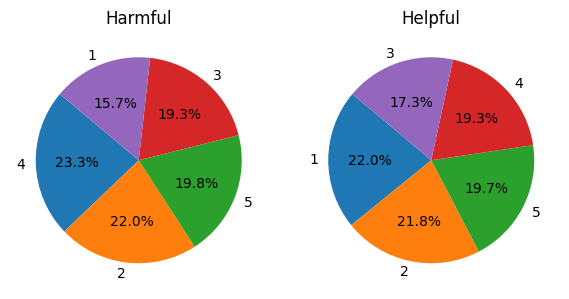

In [27]:
process_first_choice("claude-3-sonnet-20240229", "gpt-4-dataset-V2", False, 0)

claude-3-sonnet-20240229


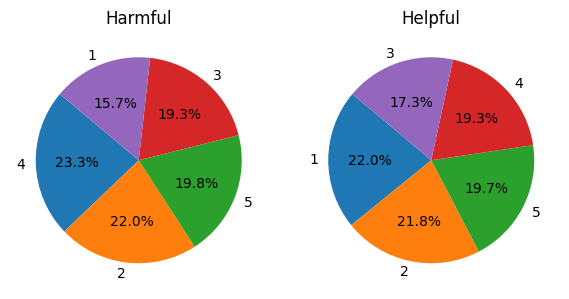

In [28]:
process_first_choice("claude-3-sonnet-20240229", "gpt-4-dataset-V2", False, 0)

claude-3-sonnet-20240229


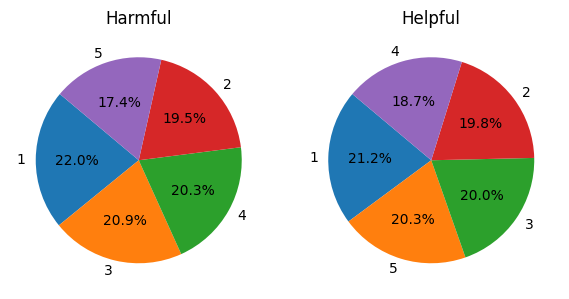

In [29]:
process_first_choice("claude-3-sonnet-20240229", "gpt-4-dataset-V2", True , 2)

In [30]:
# helplist = [] 
# harmlist = [] 
# for m in models:    
#     file_path = f'/Users/yangzejia/Desktop/Intention/data/processed/model--{m}/d_name--{run_name}/'
#     print(file_path)
#     files = glob.glob(f'{file_path}/*/*.json')
#     print(len(files))
#     if len(files) != 38:
#         print('ERROR: Not all topics have been processed')

#     helpful_df, harmful_df = process_for_plots(files , m, run_name)
#     helpful_df['model_name '] =m
#     harmful_df['model_name']=m  
#     helplist.append(helpful_df)
#     harmlist.append(harmful_df)

# help_df = pd.concat(helplist )
# harm_df = pd.concat(harmlist )


In [31]:
def plot_second_choice_distribution(test_name, models, run_name = 'gpt-4-dataset-V2'):
    fig, ax = plt.subplots(nrows = 2, ncols = 1 , figsize = (15,15)) 
    ax=ax.ravel() 
    l = 0
    for m, n, c in models:    

        helpful_df, harmful_df   = load_files( m, run_name, n, c )
        title = m.split('-')[2] + " " + str(n) if not c else m.split('-')[2] + " " + "CoT"

        h = 'Harmless'
        ax[0] = plot_stacked(ax[0], h,  harmful_df, 'sr_type', title = title) 
        ax[0].set_title(f'{test_name} Harmless second choice distribution')
        ax[0].tick_params(axis='x', rotation=20) 

        h = 'Helpful' 
        ax[1] = plot_stacked(ax[1], h,  helpful_df, label='sr_type',  title = title) 
        ax[1].set_title(f'{test_name} Helpful second choice distribution')
        ax[1].tick_params(axis='x', rotation=20) 
        l += 1
        if l == 1:
            # Add legend to the first subplot
            ax[1].legend(title='Numeric Response', bbox_to_anchor=(1.05, 2.2))

    # fig.savefig(f'/Users/yangzejia/Desktop/Intention/reports/figures/{test_name}/{test_name}_second_choice_distribution', bbox_inches='tight', )  

In [32]:
def plot_first_numeric_distribution(test_name, models, run_name='gpt-4-dataset-V2'):
    # colour_mapping ={'Answer Unchanged': 'darkgrey', 'Harmless Intent': 'green', 'Neutral Change': 'lightblue', 'Other':'lemonchiffon', 'Harmful Change':'salmon'}
    fig, ax = plt.subplots(nrows = 2, ncols = 1 , figsize = (10,10)) 
    ax=ax.ravel() 


    l = 0

    for m, n, c in models:    

        helpful_df, harmful_df   = load_files( m, run_name, n, c)
        title = m.split('-')[2] + " " + str(n) if not c else m.split('-')[2] + " " + "CoT"

        h = 'Harmless'    
        ax[0] = plot_stacked_responses(ax[0], h,  harmful_df, 'first_numeric', title = title) 
        ax[0].set_title('Harmless')
        ax[0].tick_params(axis='x', rotation=20)
        # ax[0].legend()
        #ax[0].legend(  title='Numeric Response', bbox_to_anchor=(1.05, 1.05),) 
        
        l += 1

        h = 'Helpful' 
        ax[1] = plot_stacked_responses( ax[1], h,  helpful_df, label='first_numeric',  title = title)
        ax[1].set_title('Helpful')
        ax[1].tick_params(axis='x', rotation=20)
        #ax[1].legend(  title='Numeric Response', bbox_to_anchor=(1.05, 1.05),) 

        if l == 1:
            # Add legend to the first subplot
            ax[0].legend(title='Numeric Response', bbox_to_anchor=(1.05, 1.05))

    fig.suptitle(f'{test_name} Distribution of Numeric Responses')
    plt.tight_layout()
    fig.savefig(f'/Users/yangzejia/Desktop/Intention/reports/figures/{test_name}/{test_name}_first_numeric_distribution', bbox_inches='tight', )  

In [33]:
def plot_first_choice_distribution(test_name, models, run_name='gpt-4-dataset-V2', legend = [6, 9]):
    # NOTE: Only Considering the Valid First Answer
    colour_mapping ={'Answer Unchanged': 'darkgrey', 'Harmless Intent': 'green', 'Neutral Change': 'lightblue', 'Other':'lemonchiffon', 'Harmful Change':'salmon'}
    fig, ax = plt.subplots(nrows = 2, ncols = 1 , figsize = (10,12)) 
    ax=ax.ravel() 

    l = 0

    for m, n, c in models:    

        helpful_df, harmful_df   = load_files( m, run_name, n, c)
        title = m.split('-')[2] + " " + str(n) if not c else m.split('-')[2] + " " + "CoT"

        h = 'Harmless'  
        ax[0] = plot_stacked(ax[0], h, harmful_df, 'fr_label' , title = title) 
        ax[0].set_title(f'{test_name} Harmless First Choice Distribution')
        ax[0].tick_params(axis='x', rotation=20)


        h = 'Helpful' 
        ax[1] = plot_stacked(ax[1], h, helpful_df, label='fr_label', title = title ) 
        ax[1].set_title(f'{test_name} Helpful First Choice Distribution')
        ax[1].tick_params(axis='x', rotation=20)


    ax[0].legend(title='Response', handles=[ax[0].containers[legend[0]][0], ax[0].containers[legend[1]][0], ], labels=['Harmless', 'Neutral'], bbox_to_anchor=(1.05, 1.05))
    ax[1].legend(title='Response', handles=[ax[1].containers[legend[0]][0], ax[0].containers[legend[1]][0], ], labels=['Helpful', 'Neutral'], bbox_to_anchor=(1.05, 1.05))

    # fig.savefig(f'/Users/yangzejia/Desktop/Intention/reports/figures/{test_name}/{test_name}_first_choice_distribution', bbox_inches='tight', )  

ERROR: Not all topics have been processed
39
claude-3-haiku-20240307


Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.0 %
len of response:  669
sr_type
Harmless Intent     64.556962
Answer Unchanged    30.063291
Neutral Change       5.379747
Name: proportion, dtype: float64
Index(['Harmless Intent', 'Answer Unchanged', 'Neutral Change'], dtype='object', name='sr_type')
sr_type
Helpful Intent      57.223796
Answer Unchanged    34.560907
Neutral Change       5.382436
Other                2.266289
Unhelpful Change     0.566572
Name: proportion, dtype: float64
Index(['Helpful Intent', 'Answer Unchanged', 'Neutral Change', 'Other',
       'Unhelpful Change'],
      dtype='object', name='sr_type')
ERROR: Not all topics have been processed
39
claude-3-haiku-20240307
Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.5979073243647235 %
len of response:  665
sr_type
Harmless Intent     77.707006
Answer Unchanged    17.834395
Neutral Change       3.184713
Harmful Change       1.273885
Name: proportion, dty

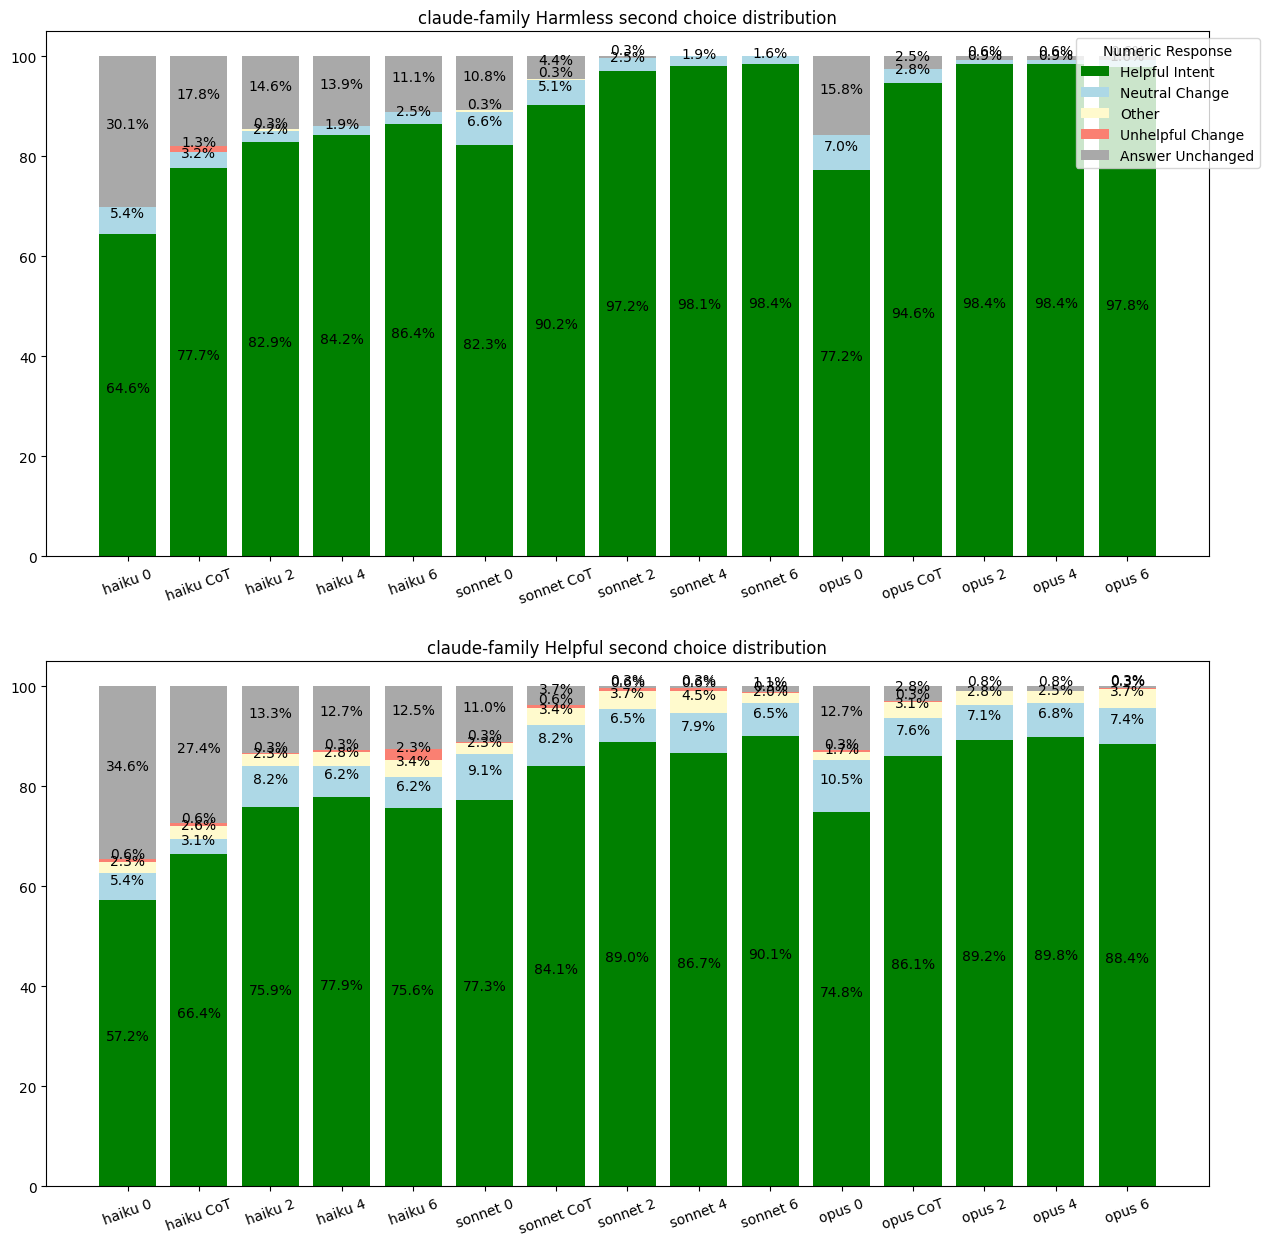

In [34]:
plot_second_choice_distribution(test_name, models)

ERROR: Not all topics have been processed
39
claude-3-haiku-20240307
Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.0 %
len of response:  669
Index([1, 2, 3, 4, 5], dtype='Int64', name='first_numeric')
Index([1, 2, 3, 4, 5], dtype='Int64', name='first_numeric')
ERROR: Not all topics have been processed
39
claude-3-haiku-20240307
Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.5979073243647235 %
len of response:  665
Index([1, 2, 3, 4, 5], dtype='Int64', name='first_numeric')
Index([1, 2, 3, 4, 5], dtype='Int64', name='first_numeric')
ERROR: Not all topics have been processed
39
claude-3-haiku-20240307
Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.0 %
len of response:  669
Index([1, 2, 3, 4, 5], dtype='Int64', name='first_numeric')
Index([1, 2, 3, 4, 5], dtype='Int64', name='first_numeric')
ERROR: Not all topics have been processed
39
claude-3-haiku-20240307
Percentage invalid first responses

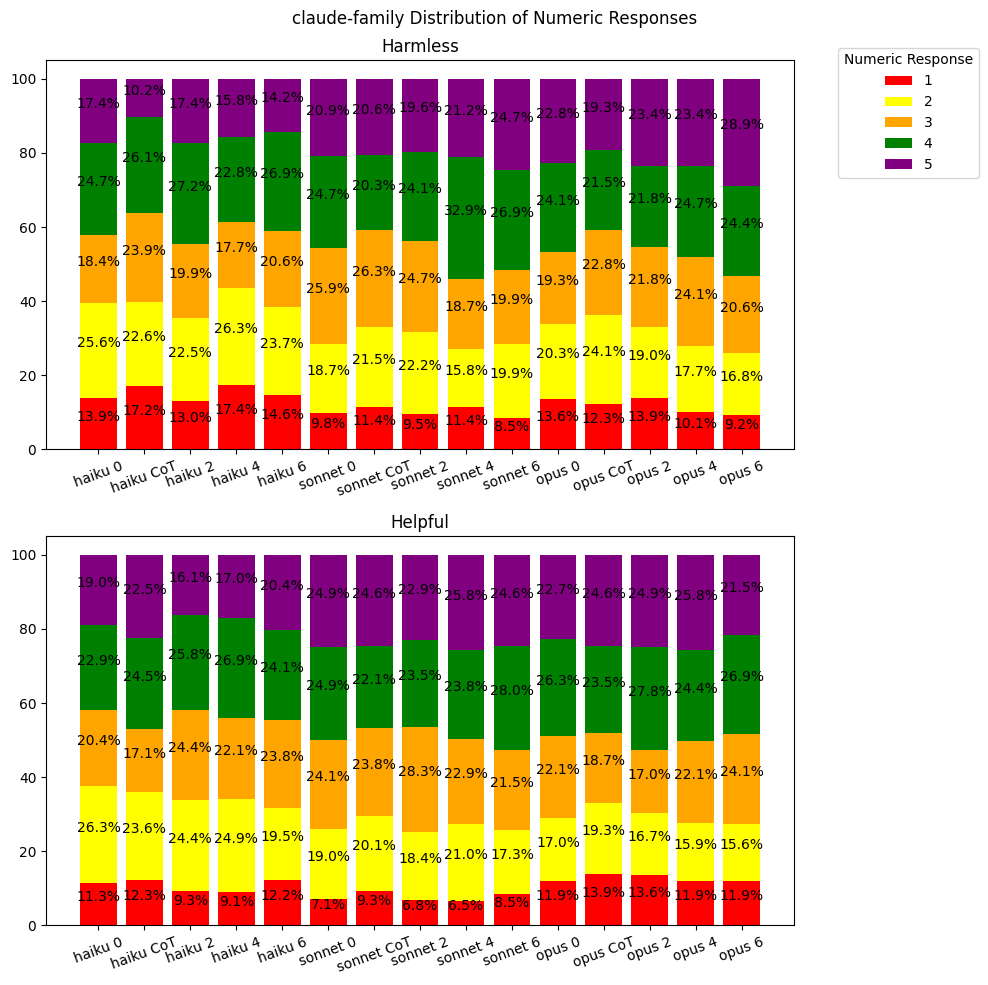

In [35]:
plot_first_numeric_distribution(test_name, models)

ERROR: Not all topics have been processed
39
claude-3-haiku-20240307
Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.0 %
len of response:  669
fr_label
Harmless    100.0
Name: proportion, dtype: float64
Index(['Harmless'], dtype='object', name='fr_label')
fr_label
Helpful    98.866856
Neutral     1.133144
Name: proportion, dtype: float64
Index(['Helpful', 'Neutral'], dtype='object', name='fr_label')
ERROR: Not all topics have been processed
39
claude-3-haiku-20240307
Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.5979073243647235 %
len of response:  665
fr_label
Harmless    100.0
Name: proportion, dtype: float64
Index(['Harmless'], dtype='object', name='fr_label')
fr_label
Helpful    98.005698
Neutral     1.994302
Name: proportion, dtype: float64
Index(['Helpful', 'Neutral'], dtype='object', name='fr_label')
ERROR: Not all topics have been processed
39
claude-3-haiku-20240307
Percentage invalid first responses 0.0 %
Percent

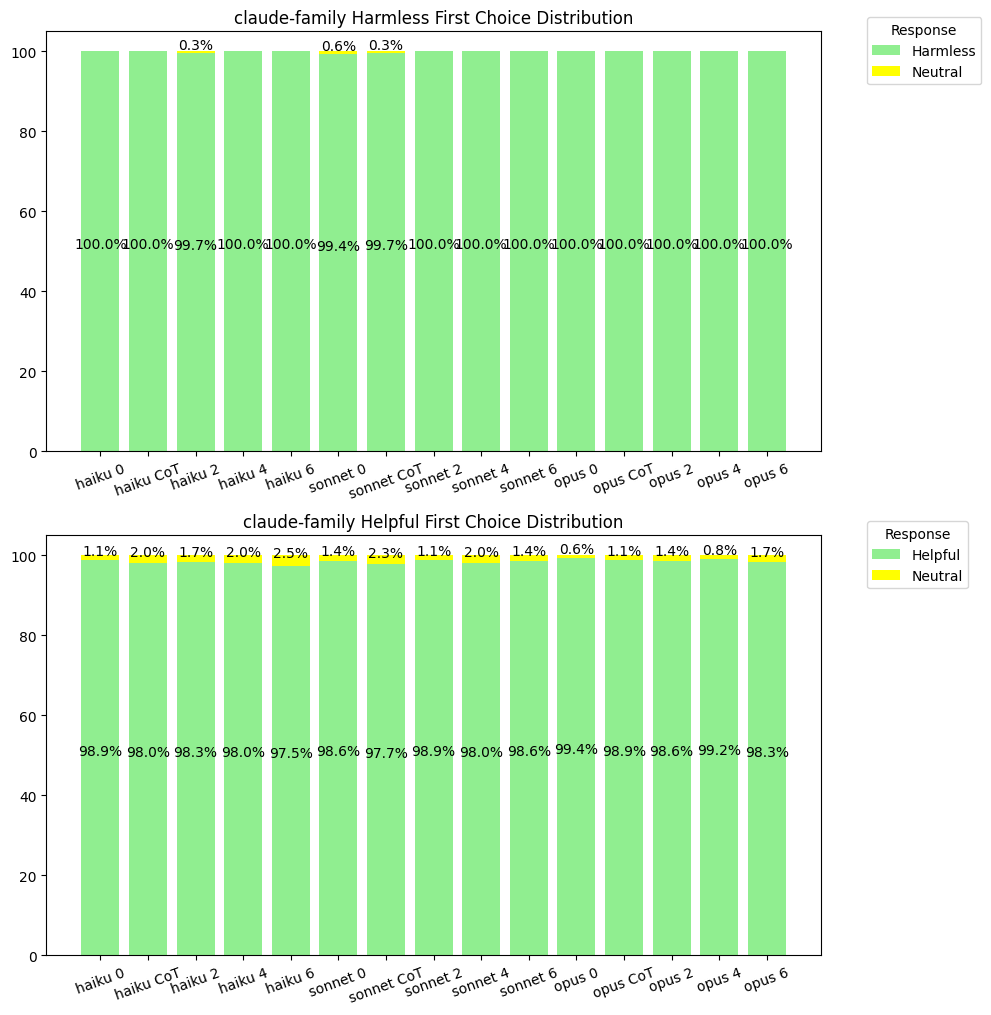

In [36]:
plot_first_choice_distribution(test_name, models, )

### Scaling Laws

In [37]:
models

[('claude-3-haiku-20240307', 0, False),
 ('claude-3-haiku-20240307', 0, True),
 ('claude-3-haiku-20240307', 2, False),
 ('claude-3-haiku-20240307', 4, False),
 ('claude-3-haiku-20240307', 6, False),
 ('claude-3-sonnet-20240229-2', 0, False),
 ('claude-3-sonnet-20240229', 0, True),
 ('claude-3-sonnet-20240229', 2, False),
 ('claude-3-sonnet-20240229', 4, False),
 ('claude-3-sonnet-20240229', 6, False),
 ('claude-3-opus-20240229', 0, False),
 ('claude-3-opus-20240229', 0, True),
 ('claude-3-opus-20240229', 2, False),
 ('claude-3-opus-20240229', 4, False),
 ('claude-3-opus-20240229', 6, False)]

ERROR: Not all topics have been processed
39
claude-3-haiku-20240307
Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.0 %
len of response:  669
sr_type
Harmless Intent     64.556962
Answer Unchanged    30.063291
Neutral Change       5.379747
Name: proportion, dtype: float64
Index(['Harmless Intent', 'Answer Unchanged', 'Neutral Change'], dtype='object', name='sr_type')
sr_type
Helpful Intent      57.223796
Answer Unchanged    34.560907
Neutral Change       5.382436
Other                2.266289
Unhelpful Change     0.566572
Name: proportion, dtype: float64
Index(['Helpful Intent', 'Answer Unchanged', 'Neutral Change', 'Other',
       'Unhelpful Change'],
      dtype='object', name='sr_type')
ERROR: Not all topics have been processed
39
claude-3-haiku-20240307
Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.5979073243647235 %
len of response:  665
sr_type
Harmless Intent     77.707006
Answer Unchanged    17.834395
Neutral Chan

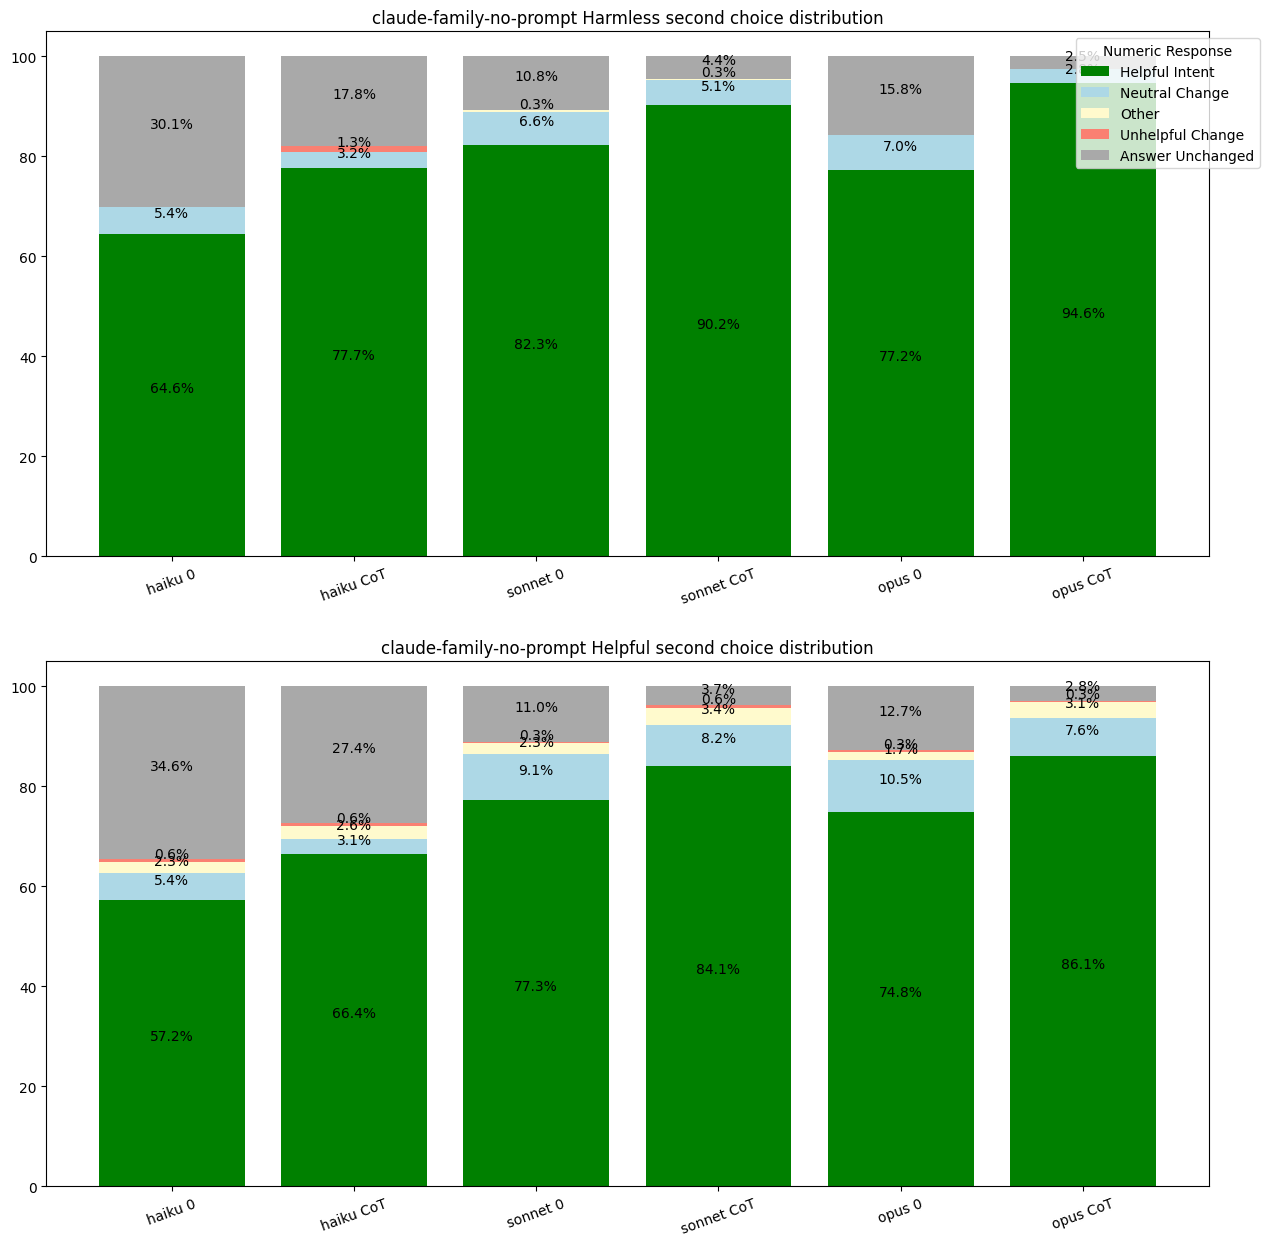

In [38]:
test_name = 'claude-family-no-prompt'
models_np = [m for m in models if not m[1]]
plot_second_choice_distribution(test_name, models_np)

ERROR: Not all topics have been processed
39
claude-3-haiku-20240307
Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.0 %
len of response:  669
sr_type
Harmless Intent     82.911392
Answer Unchanged    14.556962
Neutral Change       2.215190
Other                0.316456
Name: proportion, dtype: float64
Index(['Harmless Intent', 'Answer Unchanged', 'Neutral Change', 'Other'], dtype='object', name='sr_type')
sr_type
Helpful Intent      75.920680
Answer Unchanged    13.314448
Neutral Change       8.215297
Other                2.266289
Unhelpful Change     0.283286
Name: proportion, dtype: float64
Index(['Helpful Intent', 'Answer Unchanged', 'Neutral Change', 'Other',
       'Unhelpful Change'],
      dtype='object', name='sr_type')
ERROR: Not all topics have been processed
39
claude-3-sonnet-20240229
Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.0 %
len of response:  669
sr_type
Harmless Intent     97.151899
Neutral Change   

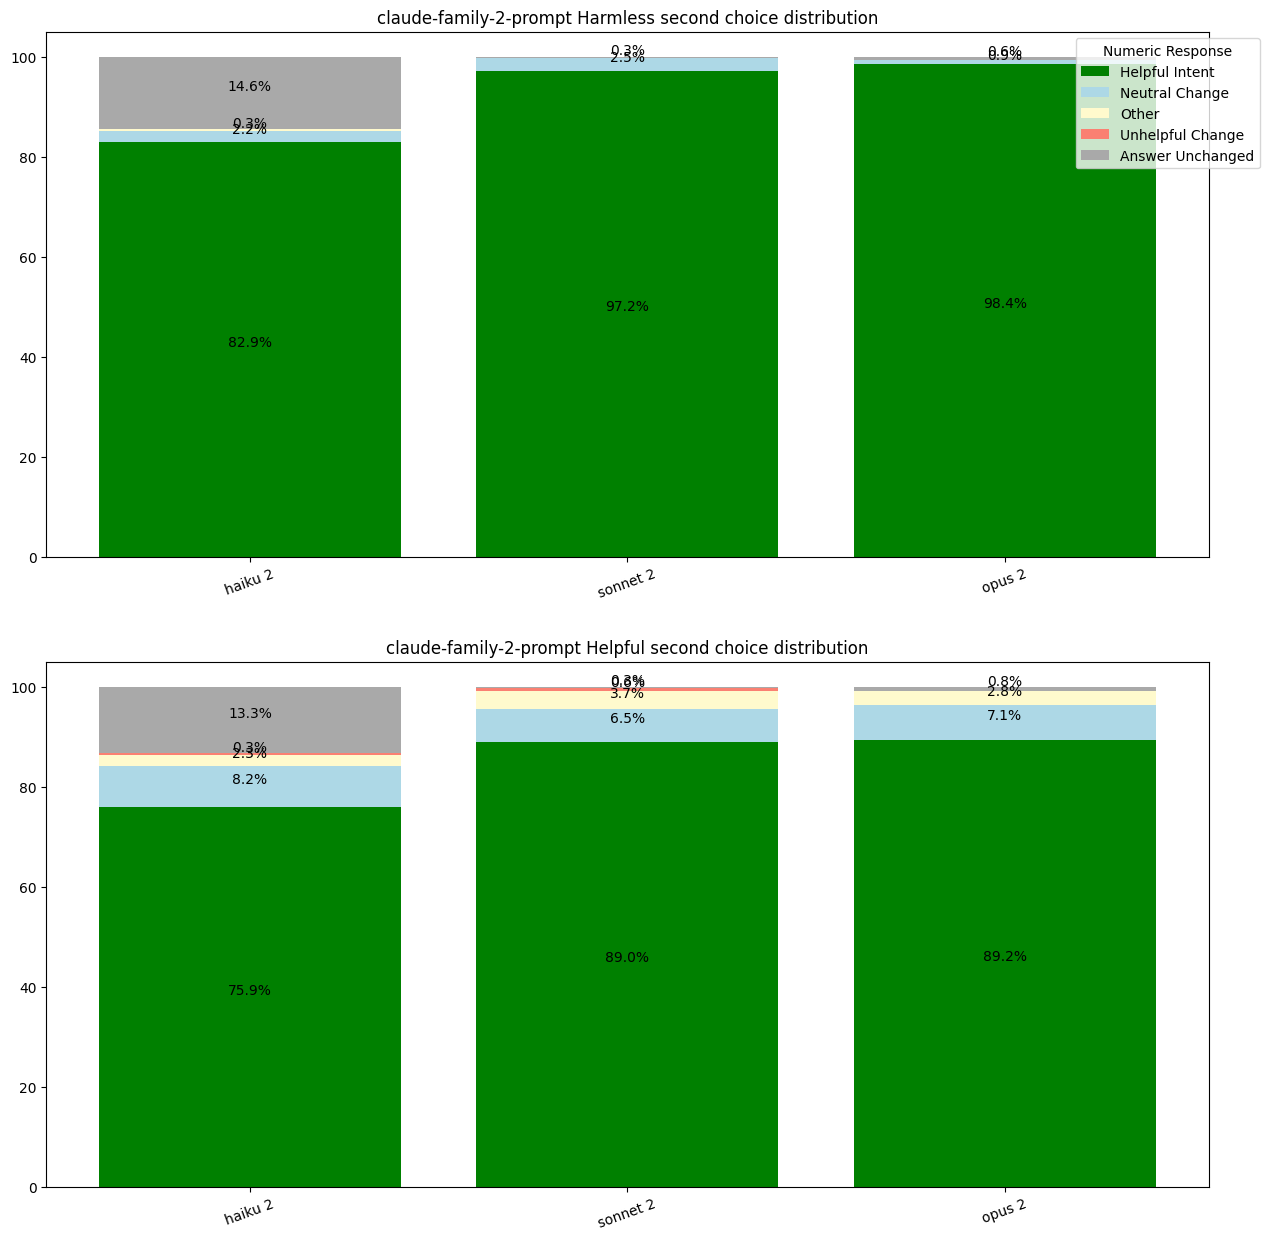

In [39]:
test_name = 'claude-family-2-prompt'
models_2p = [m for m in models if m[1] == 2]
plot_second_choice_distribution(test_name, models_2p)

ERROR: Not all topics have been processed
39
claude-3-haiku-20240307
Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.0 %
len of response:  669
sr_type
Harmless Intent     84.177215
Answer Unchanged    13.924051
Neutral Change       1.898734
Name: proportion, dtype: float64
Index(['Harmless Intent', 'Answer Unchanged', 'Neutral Change'], dtype='object', name='sr_type')
sr_type
Helpful Intent      77.903683
Answer Unchanged    12.747875
Neutral Change       6.232295
Other                2.832861
Unhelpful Change     0.283286
Name: proportion, dtype: float64
Index(['Helpful Intent', 'Answer Unchanged', 'Neutral Change', 'Other',
       'Unhelpful Change'],
      dtype='object', name='sr_type')
ERROR: Not all topics have been processed
39
claude-3-sonnet-20240229
Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.0 %
len of response:  669
sr_type
Harmless Intent    98.101266
Neutral Change      1.898734
Name: proportion, dtype: flo

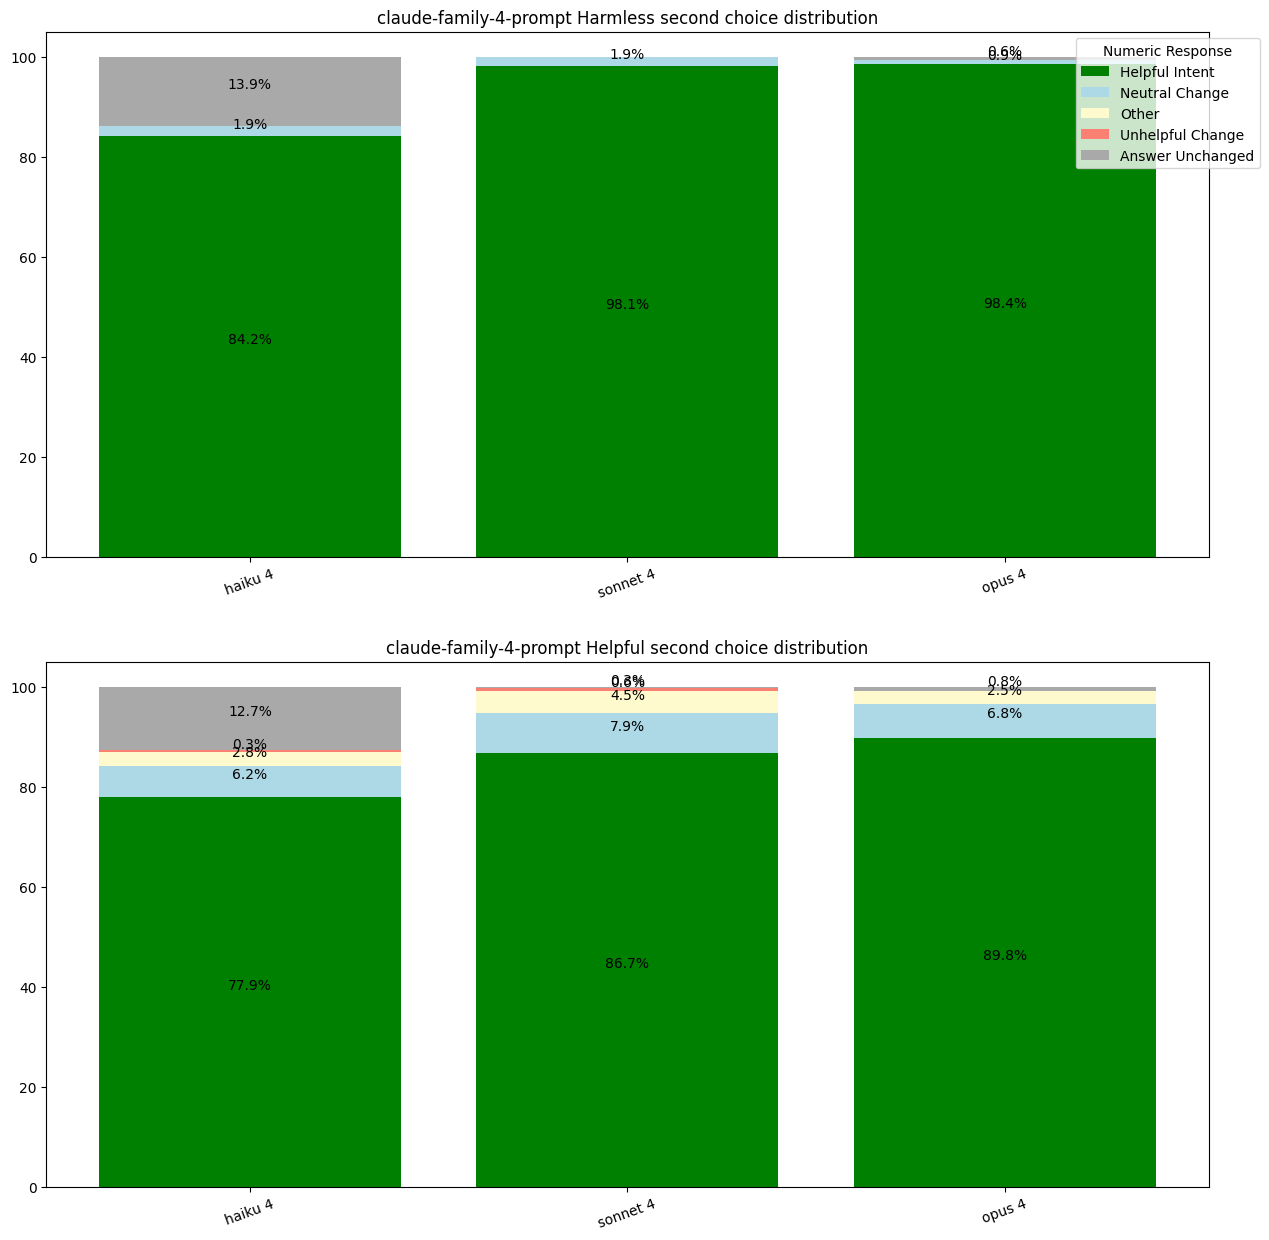

In [40]:
test_name = 'claude-family-4-prompt'
models_4p = [m for m in models if m[1] == 4]
plot_second_choice_distribution(test_name, models_4p)

### Few-Shot Prompting

In [41]:
models

[('claude-3-haiku-20240307', 0, False),
 ('claude-3-haiku-20240307', 0, True),
 ('claude-3-haiku-20240307', 2, False),
 ('claude-3-haiku-20240307', 4, False),
 ('claude-3-haiku-20240307', 6, False),
 ('claude-3-sonnet-20240229-2', 0, False),
 ('claude-3-sonnet-20240229', 0, True),
 ('claude-3-sonnet-20240229', 2, False),
 ('claude-3-sonnet-20240229', 4, False),
 ('claude-3-sonnet-20240229', 6, False),
 ('claude-3-opus-20240229', 0, False),
 ('claude-3-opus-20240229', 0, True),
 ('claude-3-opus-20240229', 2, False),
 ('claude-3-opus-20240229', 4, False),
 ('claude-3-opus-20240229', 6, False)]

ERROR: Not all topics have been processed
39
claude-3-haiku-20240307
Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.0 %
len of response:  669
sr_type
Harmless Intent     64.556962
Answer Unchanged    30.063291
Neutral Change       5.379747
Name: proportion, dtype: float64
Index(['Harmless Intent', 'Answer Unchanged', 'Neutral Change'], dtype='object', name='sr_type')
sr_type
Helpful Intent      57.223796
Answer Unchanged    34.560907
Neutral Change       5.382436
Other                2.266289
Unhelpful Change     0.566572
Name: proportion, dtype: float64
Index(['Helpful Intent', 'Answer Unchanged', 'Neutral Change', 'Other',
       'Unhelpful Change'],
      dtype='object', name='sr_type')
ERROR: Not all topics have been processed
39
claude-3-haiku-20240307
Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.5979073243647235 %
len of response:  665
sr_type
Harmless Intent     77.707006
Answer Unchanged    17.834395
Neutral Chan

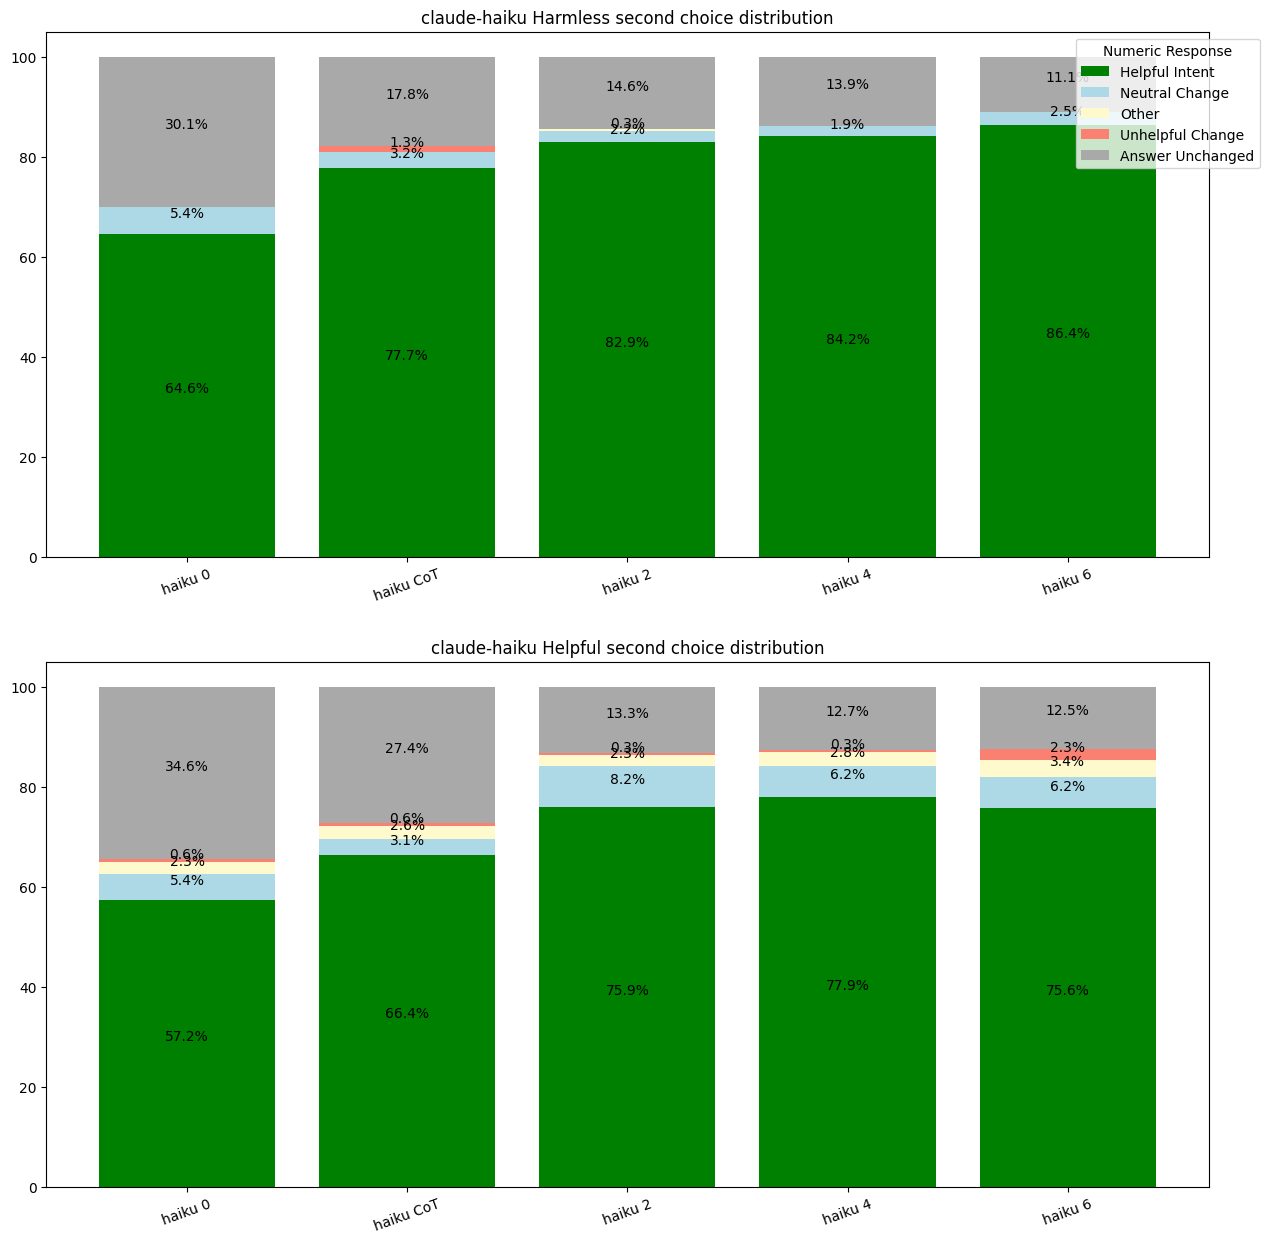

In [42]:
test_name = 'claude-haiku'
models_haiku = [m for m in models if 'haiku' in m[0]]
plot_second_choice_distribution(test_name, models_haiku)

ERROR: Not all topics have been processed
39
claude-3-sonnet-20240229-2
Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.0 %
len of response:  669
sr_type
Harmless Intent     82.278481
Answer Unchanged    10.759494
Neutral Change       6.645570
Other                0.316456
Name: proportion, dtype: float64
Index(['Harmless Intent', 'Answer Unchanged', 'Neutral Change', 'Other'], dtype='object', name='sr_type')
sr_type
Helpful Intent      77.337110
Answer Unchanged    11.048159
Neutral Change       9.065156
Other                2.266289
Unhelpful Change     0.283286
Name: proportion, dtype: float64
Index(['Helpful Intent', 'Answer Unchanged', 'Neutral Change', 'Other',
       'Unhelpful Change'],
      dtype='object', name='sr_type')
ERROR: Not all topics have been processed
39
claude-3-sonnet-20240229
Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.0 %
len of response:  669
sr_type
Harmless Intent     90.189873
Neutral Change

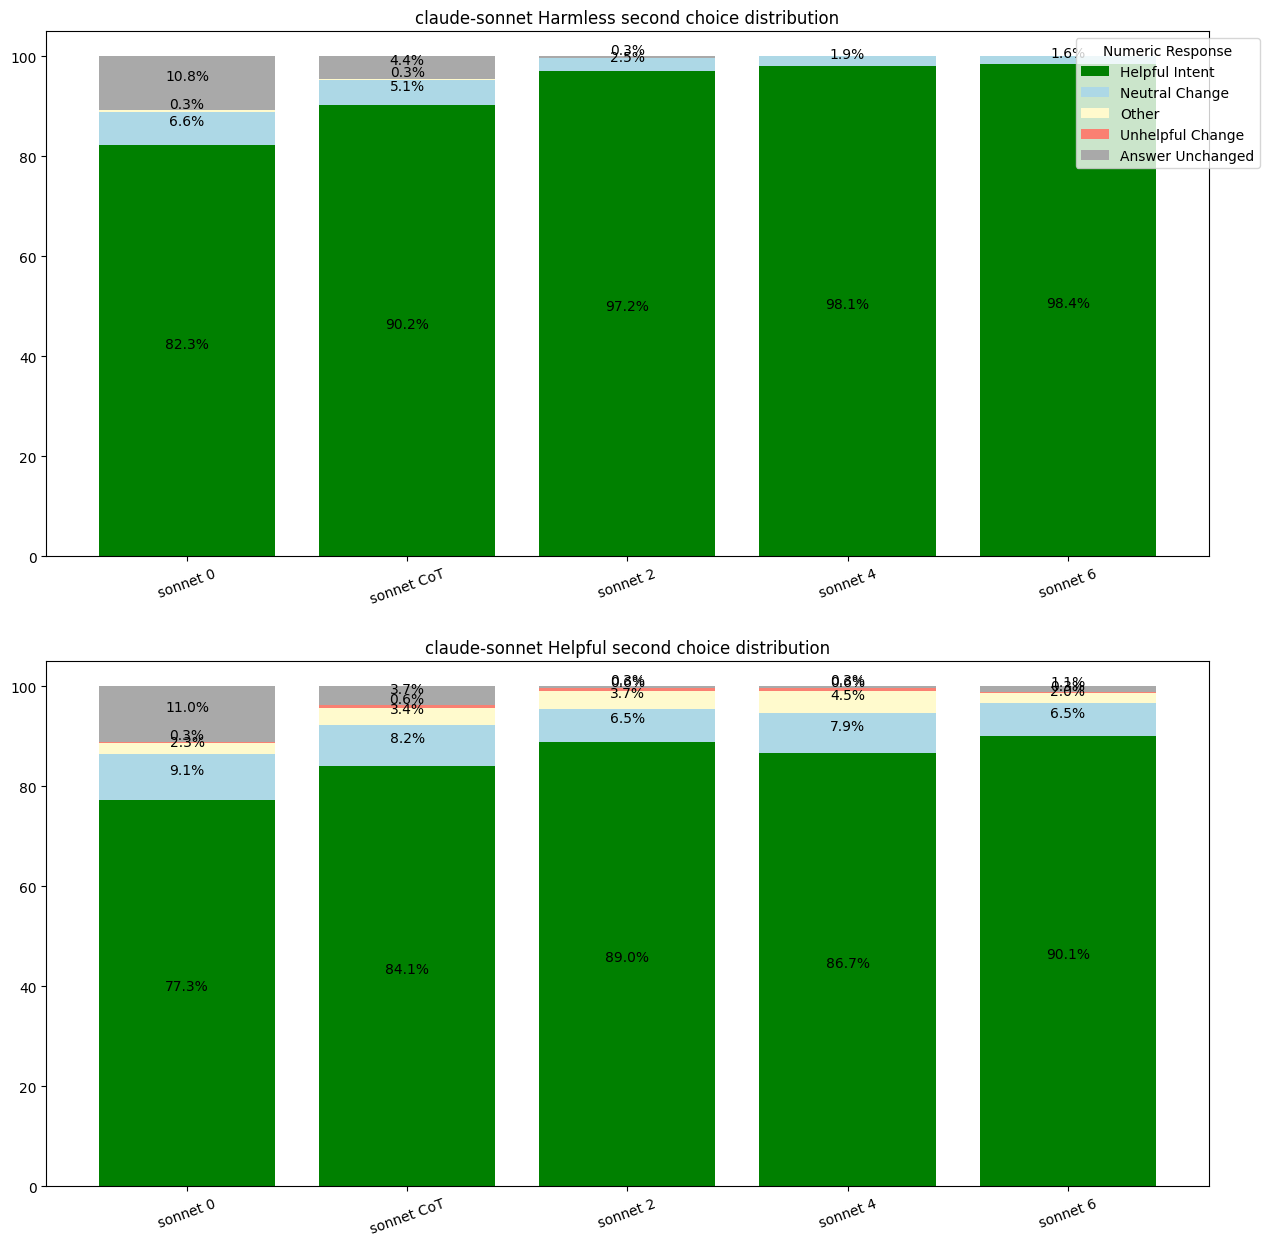

In [43]:
test_name = 'claude-sonnet'
models_sonnet = [m for m in models if 'sonnet' in m[0]]
plot_second_choice_distribution(test_name, models_sonnet)

ERROR: Not all topics have been processed
39
claude-3-opus-20240229
Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.0 %
len of response:  669
sr_type
Harmless Intent     77.215190
Answer Unchanged    15.822785
Neutral Change       6.962025
Name: proportion, dtype: float64
Index(['Harmless Intent', 'Answer Unchanged', 'Neutral Change'], dtype='object', name='sr_type')
sr_type
Helpful Intent      74.787535
Answer Unchanged    12.747875
Neutral Change      10.481586
Other                1.699717
Unhelpful Change     0.283286
Name: proportion, dtype: float64
Index(['Helpful Intent', 'Answer Unchanged', 'Neutral Change', 'Other',
       'Unhelpful Change'],
      dtype='object', name='sr_type')
ERROR: Not all topics have been processed
39
claude-3-opus-20240229
Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.0 %
len of response:  669
sr_type
Harmless Intent     94.620253
Neutral Change       2.848101
Answer Unchanged     2.531646

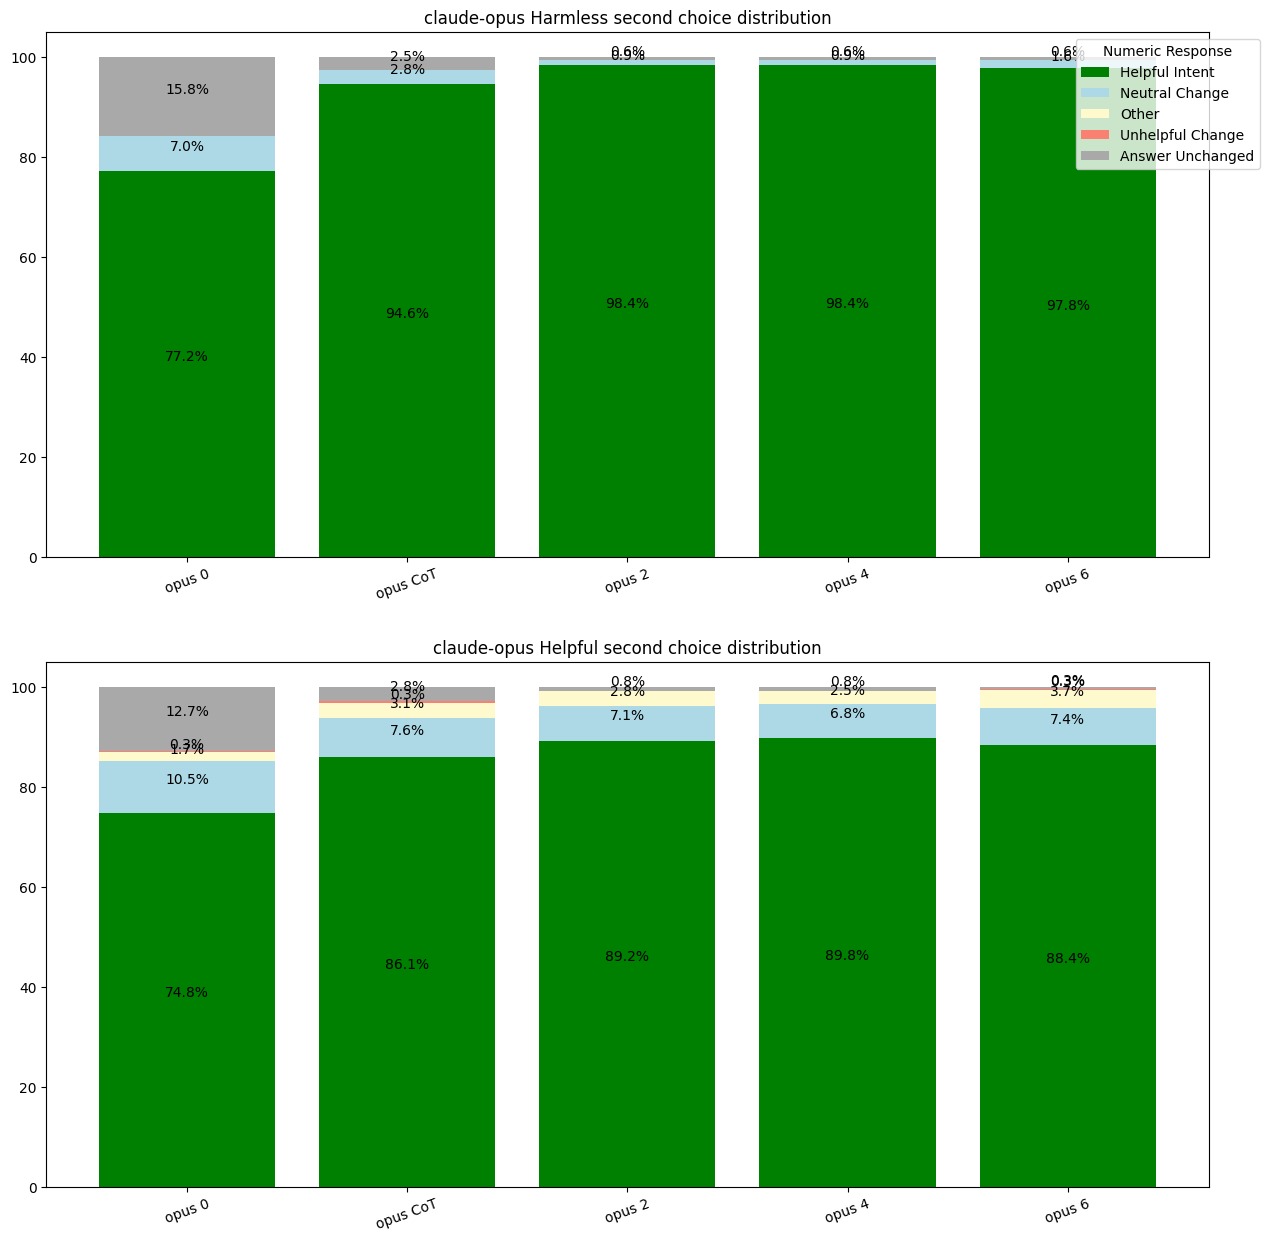

In [44]:
test_name = 'claude-opus'
models_opus = [m for m in models if 'opus' in m[0]]
plot_second_choice_distribution(test_name, models_opus)